In [1]:
import tqdm
import itertools
import types
import math
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
# PyTorch
import torch
torch.manual_seed(42)
import gpytorch

In [2]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2
# Importing our custom module(s)
import layers
import losses
import utils

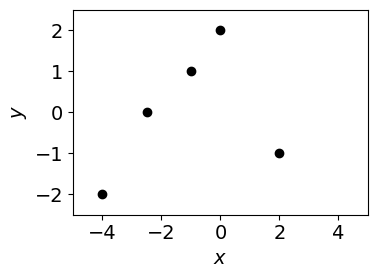

In [3]:
X_numpy, y_numpy = np.array([[-4], [-2.5], [-1], [0], [2]]), np.array([-2, 0, 1, 2, -1])

X = torch.tensor(X_numpy, dtype=torch.float32)
y = torch.tensor(y_numpy.reshape(-1, 1), dtype=torch.float32)

ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharex=True, sharey='row')
ax.scatter(X_numpy, y_numpy, color='#000000')
ax.set_xlim([-5, 5])
ax.set_ylim([-2.5, 2.5])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
fig.tight_layout()
plt.show()

In [4]:
model = layers.RandomFeatureGaussianProcess(in_features=1, out_features=1, lengthscale=1.0)
criterion = losses.ERMLoss(criterion=torch.nn.MSELoss())

init_state_dict = model.state_dict()
best_state_dict = None
best_metric = np.inf

for lr, weight_decay in itertools.product([0.1, 0.01, 0.001, 0.0001], [0.01, 0.001, 0.0001, 1e-5, 1e-6, 0.0]):
#for lr, weight_decay in itertools.product([0.1], [0.0]):
   
    model.load_state_dict(init_state_dict)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    for epoch in tqdm.tqdm(range(10_000)):
        optimizer.zero_grad()
        logits = model(X)
        params = utils.flatten_params(model)
        metrics = criterion(y, logits, params)
        metrics['loss'].backward()
        optimizer.step()
            
        if metrics['nll'] < best_metric:
            best_state_dict = model.state_dict()
            best_metric = metrics['nll']
        
model.load_state_dict(best_state_dict)
model.eval()

with torch.no_grad():
    linspace = torch.linspace(start=-5, end=5, steps=1000).view(-1, 1)
    lengthscale1_preds = model(linspace)
    torch.save(lengthscale1_preds, 'regression_lengthscale1_preds.pt')

100%|██████████| 10000/10000 [00:26<00:00, 377.18it/s]


In [5]:
model = layers.RandomFeatureGaussianProcess(in_features=1, out_features=1)
criterion = losses.ERMLoss(criterion=torch.nn.MSELoss())

init_state_dict = model.state_dict()
best_state_dict = None
best_metric = np.inf

for lr, weight_decay in itertools.product([0.1, 0.01, 0.001, 0.0001], [0.01, 0.001, 0.0001, 1e-5, 1e-6, 0.0]):
#for lr, weight_decay in itertools.product([0.1], [0.0]):
    
    model.load_state_dict(init_state_dict)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    for epoch in tqdm.tqdm(range(10_000)):
        optimizer.zero_grad()
        logits = model(X)
        params = utils.flatten_params(model)
        metrics = criterion(y, logits, params)
        metrics['loss'].backward()
        optimizer.step()
            
        if metrics['nll'] < best_metric:
            best_state_dict = model.state_dict()
            best_metric = metrics['nll']
        
model.load_state_dict(best_state_dict)
model.eval()

with torch.no_grad():
    linspace = torch.linspace(start=-5, end=5, steps=1000).view(-1, 1)
    lengthscale2_preds = model(linspace)
    torch.save(lengthscale2_preds, 'regression_lengthscale2_preds.pt')

100%|██████████| 10000/10000 [00:19<00:00, 508.94it/s]


In [6]:
model = layers.RandomFeatureGaussianProcess(in_features=1, out_features=1)
model.sigma_param = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(1e-4))))
utils.add_variational_layers(model, model.sigma_param)
model.use_posterior = types.MethodType(utils.use_posterior, model)
model.lengthscale = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(math.sqrt(20)))))
torch.nn.utils.parametrize.register_parametrization(model, 'lengthscale', torch.nn.Softplus())
model.outputscale = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(1.0))))
torch.nn.utils.parametrize.register_parametrization(model, 'outputscale', torch.nn.Softplus())
criterion = losses.KappaELBoLoss(1.0, model.sigma_param, criterion=torch.nn.MSELoss())

init_state_dict = model.state_dict()
best_state_dict = None
best_metric = np.inf

for lr, weight_decay in itertools.product([0.1, 0.01, 0.001, 0.0001], [0.0]):
#for lr, weight_decay in itertools.product([0.1], [0.0]):
    
    model.load_state_dict(init_state_dict)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    for epoch in tqdm.tqdm(range(10_000)):
        optimizer.zero_grad()
        logits = model(X)
        params = utils.flatten_params(model)
        metrics = criterion(y, logits, params)
        metrics['loss'].backward()
        optimizer.step()
            
        if metrics['loss'] < best_metric:
            best_state_dict = model.state_dict()
            best_metric = metrics['loss']
        
model.load_state_dict(best_state_dict)
model.eval()

with torch.no_grad():
    linspace = torch.linspace(start=-5, end=5, steps=1000).view(-1, 1)
    elbo_mean = model(linspace)
    model.use_posterior(True)
    elbo_samples = torch.stack([model(linspace).view(-1) for _ in range(100)])
    torch.save(elbo_mean, 'regression_elbo_mean.pt')
    torch.save(elbo_samples, 'regression_elbo_samples.pt')

100%|██████████| 10000/10000 [01:00<00:00, 164.27it/s]


In [7]:
model = layers.RandomFeatureGaussianProcess(in_features=1, out_features=1)
model.sigma_param = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(1e-4))))
utils.add_variational_layers(model, model.sigma_param)
model.use_posterior = types.MethodType(utils.use_posterior, model)
model.lengthscale = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(math.sqrt(20)))))
torch.nn.utils.parametrize.register_parametrization(model, 'lengthscale', torch.nn.Softplus())
model.outputscale = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(1.0))))
torch.nn.utils.parametrize.register_parametrization(model, 'outputscale', torch.nn.Softplus())
criterion = losses.KappaELBoLoss(len(utils.flatten_params(model))/len(X), model.sigma_param, criterion=torch.nn.MSELoss())

init_state_dict = model.state_dict()
best_state_dict = None
best_metric = np.inf

for lr, weight_decay in itertools.product([0.1, 0.01, 0.001, 0.0001], [0.0]):
#for lr, weight_decay in itertools.product([0.1], [0.0]):
    
    model.load_state_dict(init_state_dict)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    for epoch in tqdm.tqdm(range(10_000)):
        optimizer.zero_grad()
        logits = model(X)
        params = utils.flatten_params(model)
        metrics = criterion(y, logits, params)
        metrics['loss'].backward()
        optimizer.step()
            
        if metrics['loss'] < best_metric:
            best_state_dict = model.state_dict()
            best_metric = metrics['loss']
        
model.load_state_dict(best_state_dict)
model.eval()

with torch.no_grad():
    linspace = torch.linspace(start=-5, end=5, steps=1000).view(-1, 1)
    de_elbo_mean = model(linspace)
    model.use_posterior(True)
    de_elbo_samples = torch.stack([model(linspace).view(-1) for _ in range(100)])
    torch.save(de_elbo_mean, 'regression_de_elbo_mean.pt')
    torch.save(de_elbo_samples, 'regression_de_elbo_samples.pt')

100%|██████████| 10000/10000 [00:57<00:00, 173.78it/s]


In [8]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X, y.view(-1), likelihood)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()

for epoch in tqdm.tqdm(range(10_000)):
    optimizer.zero_grad()
    output = model(X)
    loss = -mll(output, y.view(-1)).sum()
    loss.backward()
    optimizer.step()
    
model.eval()
likelihood.eval()

with torch.no_grad():
    linspace = torch.linspace(start=-5, end=5, steps=1000)
    gp_preds = likelihood(model(linspace))
    gp_samples = gp_preds.sample(torch.Size((3,)))
    torch.save(gp_preds, 'regression_gp_preds.pt')
    torch.save(gp_samples, 'regression_gp_samples.pt')

100%|██████████| 10000/10000 [01:18<00:00, 126.79it/s]


In [9]:
lengthscale1_preds = torch.load('regression_lengthscale1_preds.pt', weights_only=False)
lengthscale2_preds = torch.load('regression_lengthscale2_preds.pt', weights_only=False)
elbo_mean = torch.load('regression_elbo_mean.pt', weights_only=False)
elbo_samples = torch.load('regression_elbo_samples.pt', weights_only=False)
de_elbo_mean = torch.load('regression_de_elbo_mean.pt', weights_only=False)
de_elbo_samples = torch.load('regression_de_elbo_samples.pt', weights_only=False)
gp_preds = torch.load('regression_gp_preds.pt', weights_only=False)
gp_samples = torch.load('regression_gp_samples.pt', weights_only=False)

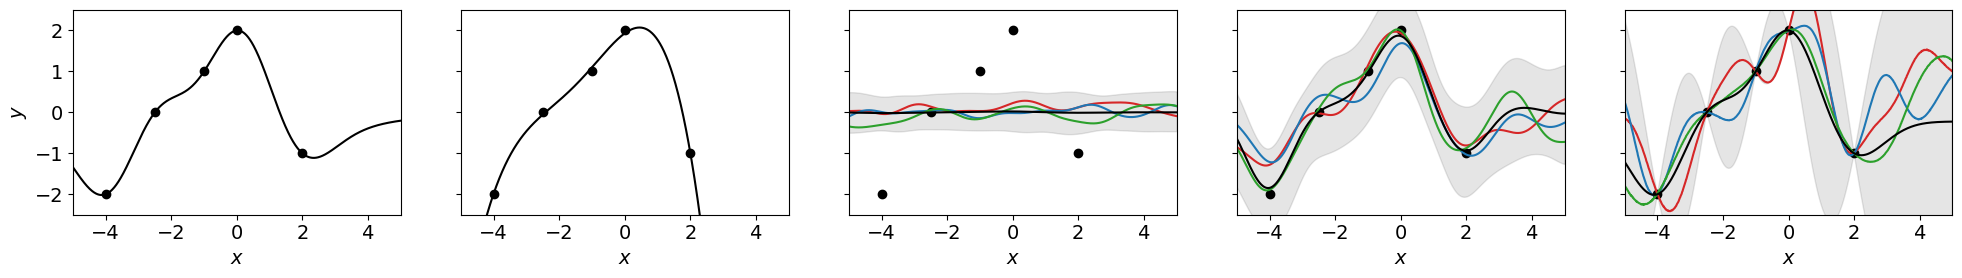

In [10]:
linspace = np.linspace(start=-5, stop=5, num=1000)

ncols, nrows = 5, 1
fig, axs = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharex=True, sharey='row')

axs[0].scatter(X_numpy, y_numpy, color='#000000')
axs[0].plot(np.linspace(start=-5, stop=5, num=1000), lengthscale1_preds, color='#000000')
axs[0].set_xlim([-5, 5])
axs[0].set_ylim([-2.5, 2.5])
axs[0].set_xlabel(r'$x$')
axs[0].set_ylabel(r'$y$')

axs[1].scatter(X_numpy, y_numpy, color='#000000')
axs[1].plot(linspace, lengthscale2_preds, color='#000000')
axs[1].set_xlim([-5, 5])
axs[1].set_ylim([-2.5, 2.5])
axs[1].set_xlabel(r'$x$')

axs[2].scatter(X_numpy, y_numpy, color='#000000')
axs[2].fill_between(np.linspace(start=-5, stop=5, num=1000), elbo_samples.mean(dim=0)+3*elbo_samples.std(dim=0), elbo_samples.mean(dim=0)-3*elbo_samples.std(dim=0), alpha=0.1, color='#000000')
axs[2].plot(linspace, elbo_samples[0], color='#D62728')
axs[2].plot(linspace, elbo_samples[1], color='#1F77B4')
axs[2].plot(linspace, elbo_samples[2], color='#2CA02C')
axs[2].plot(linspace, elbo_mean, color='#000000')
axs[2].set_xlim([-5, 5])
axs[2].set_ylim([-2.5, 2.5])
axs[2].set_xlabel(r'$x$')

axs[3].scatter(X_numpy, y_numpy, color='#000000')
axs[3].fill_between(np.linspace(start=-5, stop=5, num=1000), de_elbo_samples.mean(dim=0)+3*de_elbo_samples.std(dim=0), de_elbo_samples.mean(dim=0)-3*de_elbo_samples.std(dim=0), alpha=0.1, color='#000000')
axs[3].plot(linspace, de_elbo_samples[0], color='#D62728')
axs[3].plot(linspace, de_elbo_samples[1], color='#1F77B4')
axs[3].plot(linspace, de_elbo_samples[2], color='#2CA02C')
axs[3].plot(linspace, de_elbo_mean, color='#000000')
axs[3].set_xlim([-5, 5])
axs[3].set_ylim([-2.5, 2.5])
axs[3].set_xlabel(r'$x$')

axs[4].scatter(X_numpy, y_numpy, color='#000000')
axs[4].fill_between(np.linspace(start=-5, stop=5, num=1000), gp_preds.mean+3*gp_preds.stddev, gp_preds.mean-3*gp_preds.stddev, alpha=0.1, color='#000000')
axs[4].plot(linspace, gp_samples[0], color='#D62728')
axs[4].plot(linspace, gp_samples[1], color='#1F77B4')
axs[4].plot(linspace, gp_samples[2], color='#2CA02C')
axs[4].plot(linspace, gp_preds.mean, color='#000000')
axs[4].set_xlim([-5, 5])
axs[4].set_ylim([-2.5, 2.5])
axs[4].set_xlabel(r'$x$')

fig.tight_layout()
fig.savefig('regression_demo.pdf', bbox_inches='tight')
plt.show()